# Temporal Analysis of SIF and XCO2
---

In [6]:
import numpy as np
import pandas as pd
import xarray

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from dask.distributed import Client
# client = Client(n_workers=16, dashboard_address=":8889")
# client

Client Scheduler: tcp://127.0.0.1:44573 Dashboard: http://127.0.0.1:8889/status,Cluster Workers: 16 Cores: 64 Memory: 270.51 GB


## Data processing

In [3]:
def prep_sif(ds):
    """Preprocess a SIF Lite file"""
    
    # Drop unused variables
    variable_list = ["Daily_SIF_740nm", "SIF_Uncertainty_740nm", "Quality_Flag", "Longitude", "Latitude", "Delta_Time"]
    ds = ds[variable_list]
    
    # Apply quality filters
    ds["SIF_plus_3sig"] = ds.Daily_SIF_740nm + 3*ds.SIF_Uncertainty_740nm
    ds = ds.where(ds.Quality_Flag != 2, drop=True)
    ds = ds.where(ds.SIF_plus_3sig > 0, drop=True)

    # Format dataset
    dsnew = xarray.Dataset(
        {
            "sif": (["time"], ds.Daily_SIF_740nm),
        },
        coords={
            "lon": (["time"], ds.Longitude),
            "lat": (["time"], ds.Latitude),
            "time": ds.Delta_Time.values
        }
    )
    return dsnew


def prep_xco2(ds):
    """Preprocess an FP Lite file"""
    
    # Drop unused variables
    variable_list = ["xco2", "xco2_quality_flag", "longitude", "latitude", "time"]
    ds = ds[variable_list]
    
    # Apply quality filters
    ds = ds.where(ds.xco2_quality_flag == 0, drop=True)

    # Format dataset
    dsnew = xarray.Dataset(
        {
            "xco2": (["time"], ds.xco2),
        },
        coords={
            "lon": (["time"], ds.longitude),
            "lat": (["time"], ds.latitude),
            "time": ds.time.values
        }
    )
    return dsnew

In [4]:
# Open datasets for all years
paths_sif = "/data/OCO-2/OCO2_L2_Lite_SIF.10r/*/*.nc4"
paths_xco2 = "/data/OCO-2/OCO2_L2_Lite_FP.10r/*/*.nc4"

DS_sif = xarray.open_mfdataset(paths_sif, preprocess=prep_sif, 
                               parallel=True)
DS_xco2 = xarray.open_mfdataset(paths_xco2, preprocess=prep_xco2, 
                                parallel=True)

## Monthly time series comparison

In [23]:
# Compute monthly climatologies
df_sif = DS_sif.sif.resample(time="1MS").mean(dim="time").to_dataframe()
df_xco2 = DS_xco2.xco2.resample(time="1MS").mean(dim="time").to_dataframe()

# Merge dataframes
df = pd.merge(df_sif, df_xco2, how="outer", on=["time"]).reset_index()
# df["time"] = df.time.dt.strftime("%Y-%m")

df.head()

,time,sif,xco2
0,2014-09-01,0.168572,395.663696
1,2014-10-01,0.124161,396.069519
2,2014-11-01,0.075926,396.865021
3,2014-12-01,0.071579,397.389465
4,2015-01-01,0.080472,397.781097


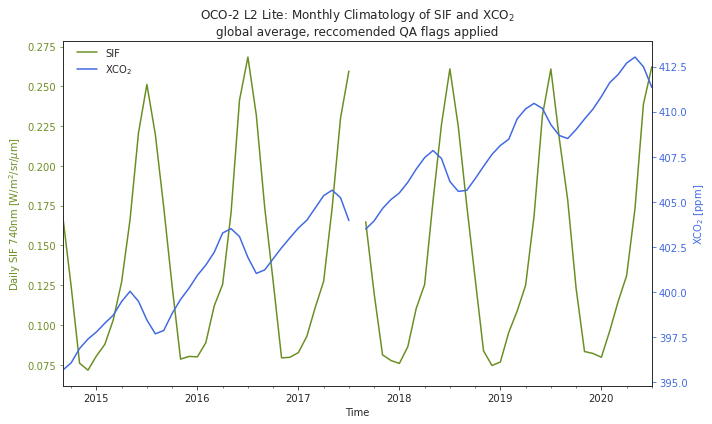

In [35]:
# Plot raw global average climatology
sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df.plot(x="time", y="sif", color=sif_color, ax=ax1, legend=False, label="SIF")
df.plot(x="time", y="xco2", color=xco2_color, ax=ax2, legend=False, label="XCO$_2$")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite: Monthly Climatology of SIF and XCO$_2$\n"
              "global average, reccomended QA flags applied")

plt.tight_layout()
plt.savefig("../plots/monthly_climatology_comparison.png")

## Remove trend to study seasonality of anomalies

In [98]:
# Interpolate missing values
df_full = df.interpolate().set_index("time")

# Fit trends by least squares
X = (df_full.index - df_full.index[0]).days.values.reshape(-1, 1)
trend_sif = LinearRegression().fit(X, df_full.sif).predict(X)
trend_xco2 = LinearRegression().fit(X, df_full.xco2).predict(X)

# Remove trends
df_full["sif_anom"] = df_full.sif - trend_sif
df_full["xco2_anom"] = df_full.xco2 - trend_xco2

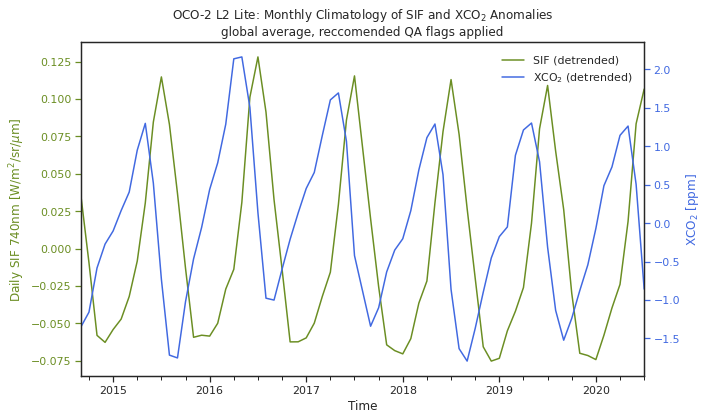

In [105]:
# Plot anomaly climatology
sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df_full.plot(y="sif_anom", use_index=True, color=sif_color, ax=ax1, legend=False, label="SIF (detrended)")
df_full.plot(y="xco2_anom", use_index=True, color=xco2_color, ax=ax2, legend=False, label="XCO$_2$ (detrended)")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite: Monthly Climatology of SIF and XCO$_2$ Anomalies\n"
              "global average, reccomended QA flags applied")

plt.tight_layout()
plt.savefig("../plots/monthly_climatology_detrended.png")

## Decompose series and look at correlation of residuals

In [92]:
df_full.set_index("time", inplace=True)

# Decompose each series
decomp_sif = sm.tsa.seasonal_decompose(df_full.sif)
decomp_xco2 = sm.tsa.seasonal_decompose(df_full.xco2)

# Merge data frames
df_resid = pd.merge(decomp_sif.resid, decomp_xco2.resid, how="inner", on=["time"])
df_resid.rename(columns={"resid_x": "SIF residual", "resid_y": "XCO2 residual"}, inplace=True);

In [93]:
sns.set_theme("notebook")

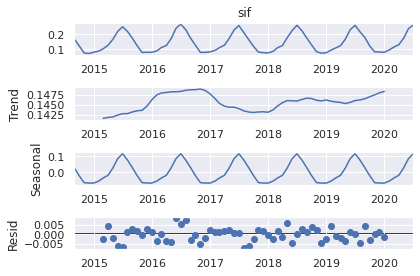

In [94]:
decomp_sif.plot();

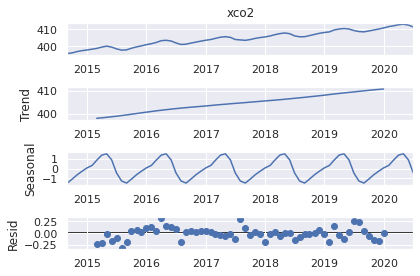

In [63]:
decomp_xco2.plot();

<Figure size 576x576 with 0 Axes>

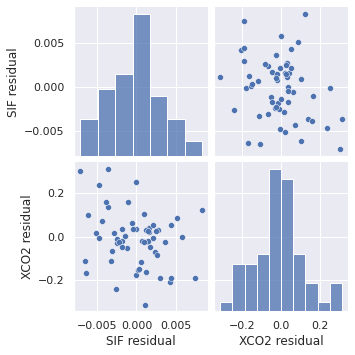

In [54]:
sns.pairplot(data=df_resid);